## 1. Install and Import

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Visualize and Build Dataset

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.KSRKC8_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.KSRKC8_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next()['label']

2

In [6]:
import numpy as np

In [7]:
#setup connection aka an iterator
data_iterator = ds.as_numpy_iterator()

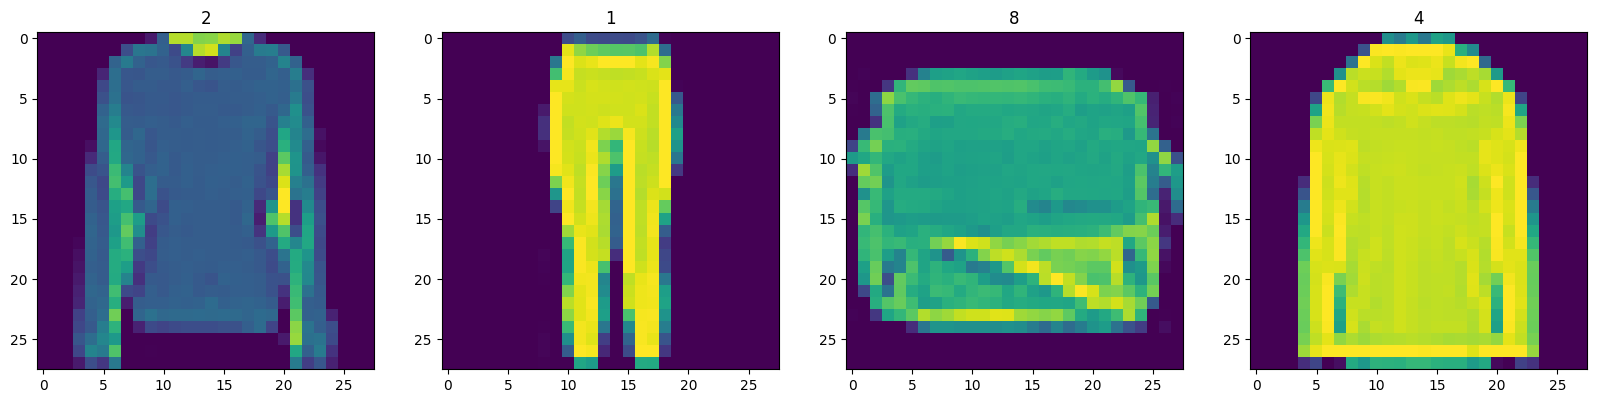

In [8]:
#seeing the data
#set figure format
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for i in range(4):
    sample = data_iterator.next()
    #np.squeeze reshapes from (28, 28, 1) to (28, 28)
    ax[i].imshow(np.squeeze(sample['image']))
    ax[i].title.set_text(sample['label'])

In [9]:
sample['image'].shape

(28, 28, 1)

In [10]:
#scaling images pixel values to 0-1 range
#pixel values are 8-bit hence can have 256 values from 0-255. Represents intensity of pixel. Independent of shape
def scale_images(data):
    image = data['image']
    return image/255

In [11]:
#steps to build a data pipeline
# map, cache, shuffle, batch, prefetch
#scale the images
ds = ds.map(scale_images)
#cache the dataset for that batch
ds = ds.cache()
#shuffle it
ds = ds.shuffle(60000)
#batch into 128
ds = ds.batch(128)
#reduces the likelihood of bottleneck
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build Neural Network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### 3.1 Build Generator

In [14]:
def build_generator():
    model = Sequential()

    #Takes in random values and reshapes it to 7x7x128
    #Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    #Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    #Conv Layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [15]:
generator = build_generator()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


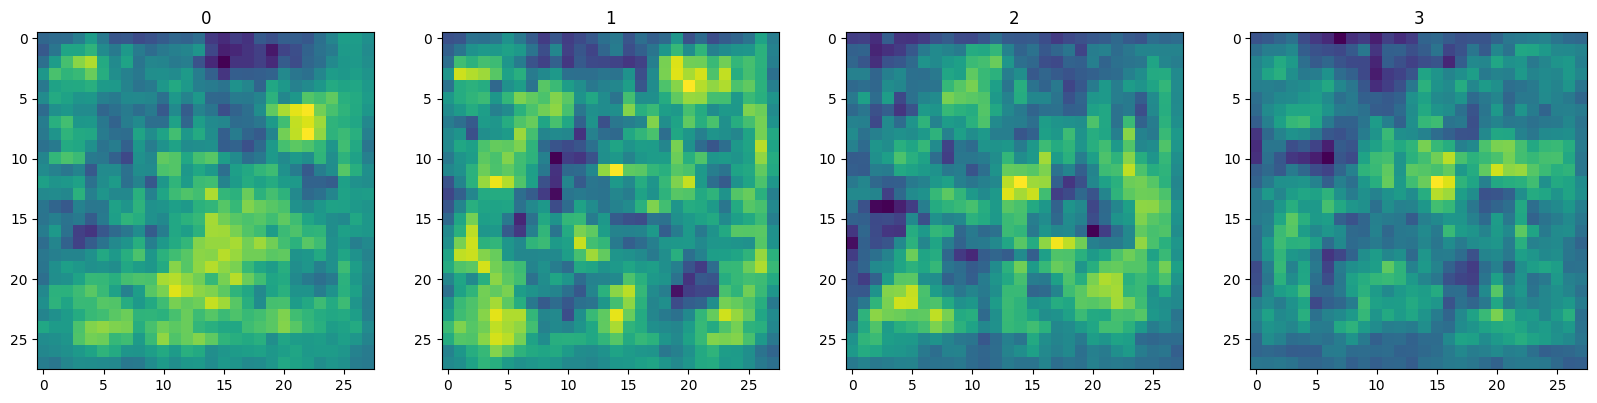

In [17]:
#testing generator predictions
img = generator.predict(np.random.randn(4,128))

#plot
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for i, im in enumerate(img):
    ax[i].imshow(np.squeeze(im))
    ax[i].title.set_text(i)

#### 3.2 Build Discriminator

In [18]:
def build_discriminator():
    model = Sequential()

    #First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Flatten and Dense
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [19]:
discriminator = build_discriminator()

In [20]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [21]:
discriminator.predict(img)

1/1 [==============================] - 0s 338ms/step


array([[0.48983303],
       [0.48975506],
       [0.4896122 ],
       [0.48968646]], dtype=float32)

## 4. Construct Training Loop

#### 4.1 Setup Losses and Optimizers

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
gen_opt = Adam(learning_rate = 0.0001)
disc_opt = Adam(learning_rate = 0.00001)
gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

#### 4.2 Build Subclassed Model

In [24]:
#Importing the base model to subclass from
from tensorflow.keras.models import Model

In [25]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    #corresponds to the fit method
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128)), training=False)

        #Train the discriminator
        with tf.GradientTape() as disc_tape:
            #discriminator output
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat = tf.concat([yhat_real, yhat_fake], axis = 0)

            #create labels
            y = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0)

            #add noise to outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y += tf.concat([noise_real, noise_fake], axis = 0)

            #calculate loss - BinaryCrossEntropy
            total_d_loss = self.disc_loss(y, yhat)

        #Apply backpropagation
        disc_grad = disc_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.disc_opt.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))

        #Train the generator
        with tf.GradientTape() as gen_tape:
            #Generate some new test images
            gen_images = self.generator(tf.random.normal((128, 128)), training = True)

            #Create predicted labels
            predicted_labels = self.discriminator(gen_images, training = False)

            #Calculate loss
            total_g_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #Apply backprop
        gen_grad = gen_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(gen_grad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss": total_g_loss}

    #corresponds to the evaluate method
    #def test_step(self):


In [26]:
fashgan = FashionGAN(generator, discriminator)

In [27]:
fashgan.compile(gen_opt, disc_opt, gen_loss, disc_loss)

#### 4.3 Build Callback

In [28]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [29]:
class ModelMonitor(Callback):
    def __init__(self, num_img = 3, latent_dim = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs= None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

#### 4.4 Train

In [37]:
#Recommended 2000 epochs
hist = fashgan.fit(ds, epochs = 500)

Epoch 1/500
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6934 - g_loss: 0.6417
Epoch 2/500
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6945 - g_loss: 0.6407
Epoch 3/500
469/469 [==============================] - 76s 163ms/step - d_loss: 0.6654 - g_loss: 0.7292
Epoch 4/500
469/469 [==============================] - 76s 163ms/step - d_loss: 0.6908 - g_loss: 0.5686
Epoch 5/500
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6940 - g_loss: 0.6199
Epoch 6/500
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6920 - g_loss: 0.6352
Epoch 7/500
450/469 [===========================>..] - ETA: 3s - d_loss: 0.6948 - g_loss: 0.6358

KeyboardInterrupt: 

#### 4.5 Review Performance

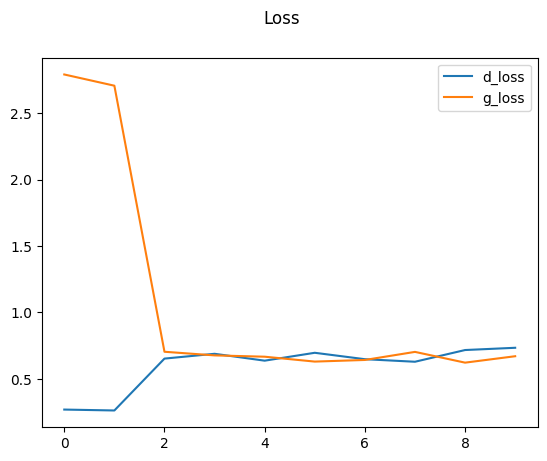

In [38]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label = 'g_loss')
plt.legend()
plt.show()

## 5. Test Generator

#### 5.1 Generate Images

In [39]:
imgs = generator.predict(tf.random.normal((16, 128)))

1/1 [==============================] - 0s 17ms/step


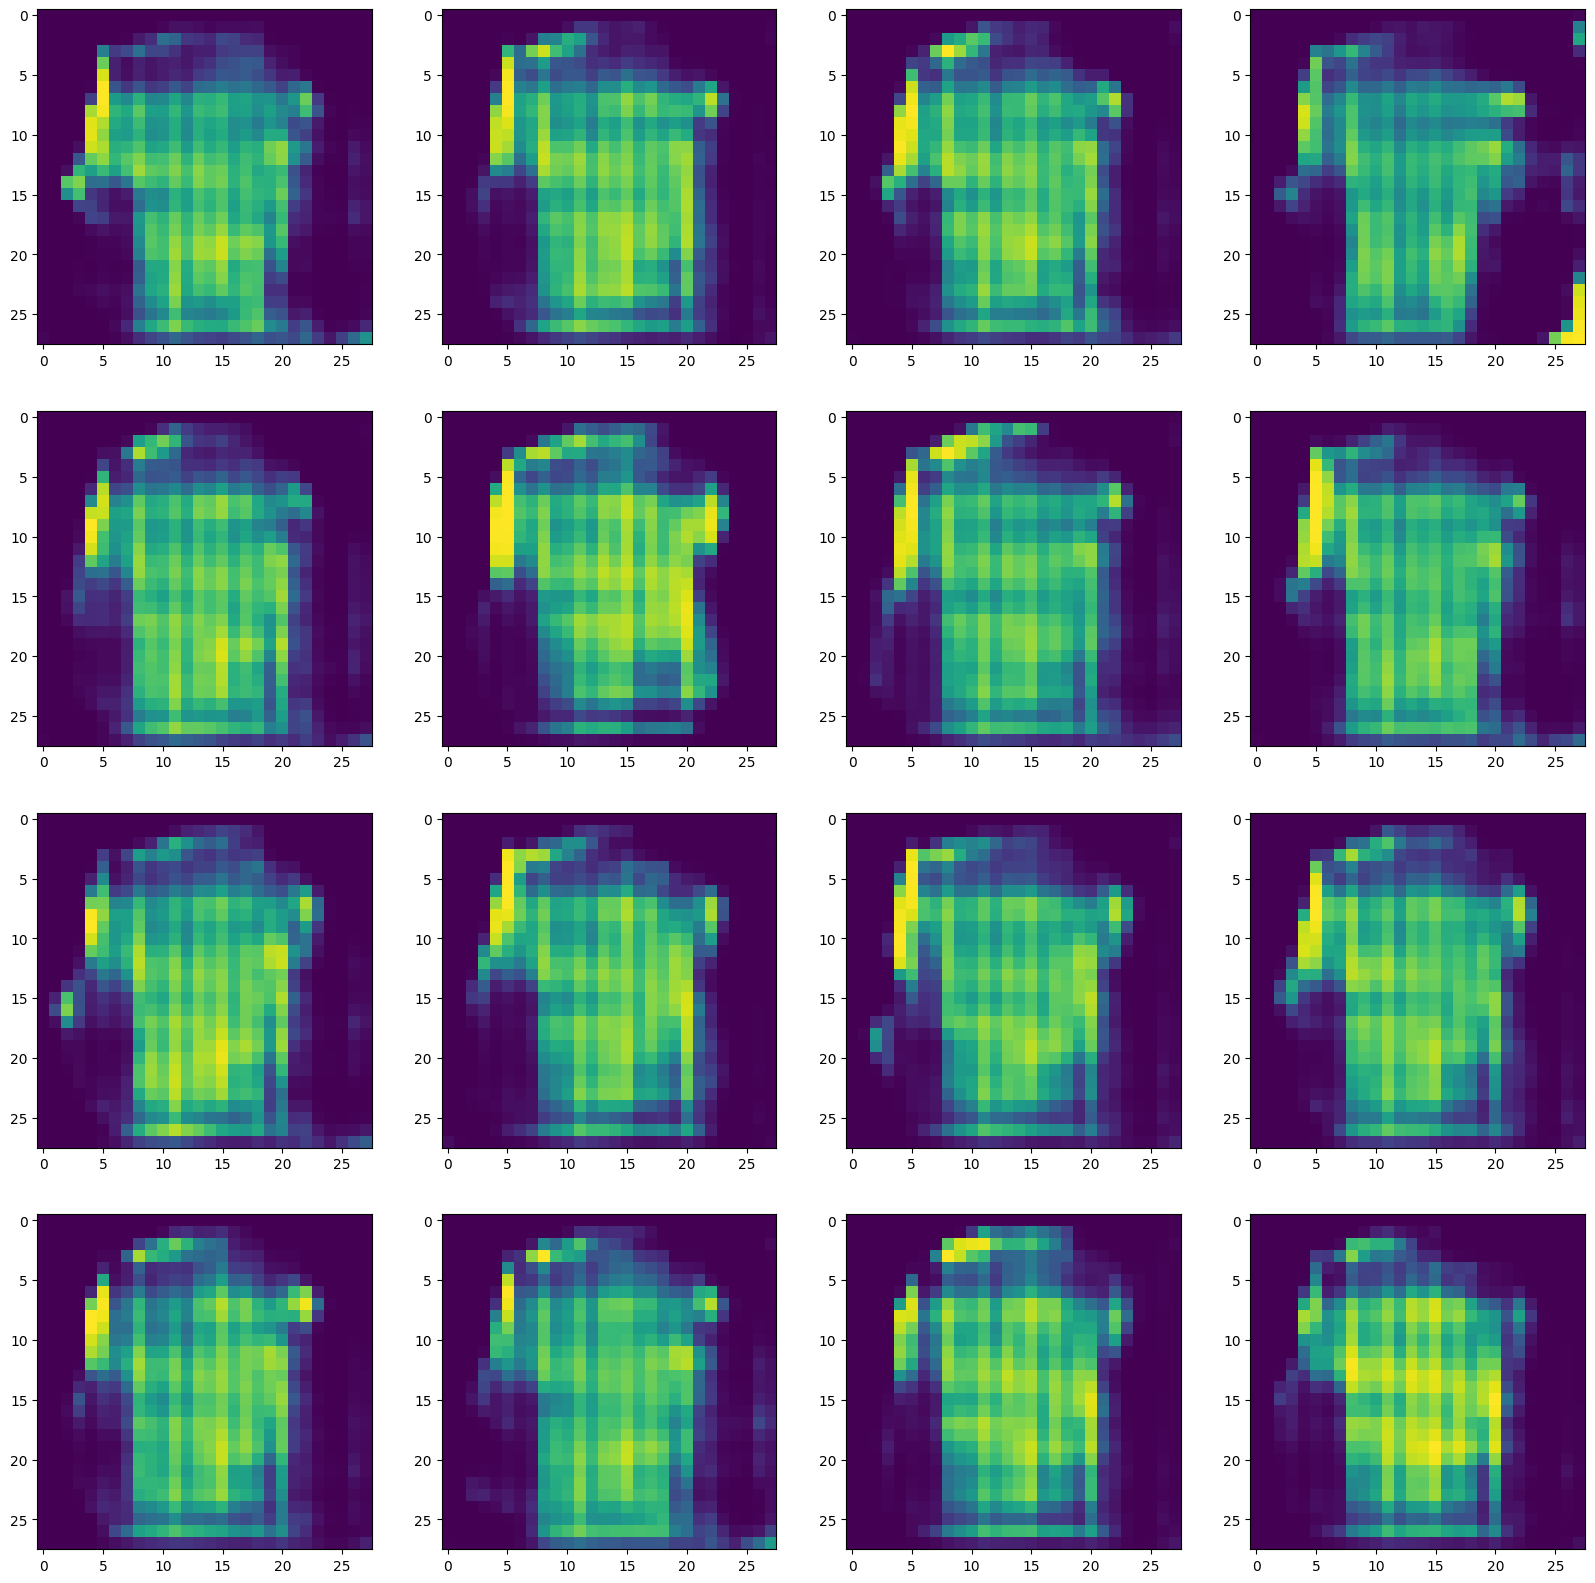

In [40]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
counter = 0
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[counter])
    counter+=1